# Battle of the Titans: XGBoost vs LightGBM vs CatBoost

We are now entering the territory of modern Machine Learning competitions. These three libraries are the industry standards for tabular data.

### The Contenders
1.  **XGBoost (eXtreme Gradient Boosting):** The original king. Famous for dominating Kaggle competitions approx 2014-2016. Optimized for speed and performance.
2.  **LightGBM (Light Gradient Boosting Machine):** Developed by Microsoft. It uses a different tree-growing strategy (Leaf-wise vs Level-wise) which makes it **insanely** fast on large datasets.
3.  **CatBoost (Categorical Boosting):** Developed by Yandex. It handles **Categorical Features** automatically (no need for One-Hot Encoding!) and often yields state-of-the-art accuracy with default parameters.

In [9]:
# Install libraries if not already installed
%pip install xgboost lightgbm catboost

## Create a Massive Dataset
To see the speed difference, we need a LOT of data. We'll generate a synthetic dataset with **100,000 samples**.

In [10]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Generate Synthetic Data
X, y = make_classification(n_samples=100000, n_features=20, n_informative=15, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size:     {X_test.shape[0]} samples")

Training Set Size: 80000 samples
Test Set Size:     20000 samples


## Train and Time the Models
We will train each model and measure exactly how long it takes.

In [11]:
results = {'Model': [], 'Accuracy': [], 'Time (s)': []}

def evaluate_model(model, name):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    
    elapsed = end_time - start_time
    results['Model'].append(name)
    results['Accuracy'].append(acc)
    results['Time (s)'].append(elapsed)
    
    print(f"{name}: Accuracy = {acc:.4f} | Time = {elapsed:.2f}s")

# 1. XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
evaluate_model(xgb_model, 'XGBoost')

# 2. LightGBM
lgbm_model = lgb.LGBMClassifier(random_state=42)
evaluate_model(lgbm_model, 'LightGBM')

# 3. CatBoost (Verbose=0 to silence the training log)
cat_model = CatBoostClassifier(verbose=0, random_state=42)
evaluate_model(cat_model, 'CatBoost')

XGBoost: Accuracy = 0.9785 | Time = 2.70s
[LightGBM] [Info] Number of positive: 40012, number of negative: 39988
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500150 -> initscore=0.000600
[LightGBM] [Info] Start training from score 0.000600


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: Accuracy = 0.9677 | Time = 1.91s
CatBoost: Accuracy = 0.9829 | Time = 27.73s


## The Results: Visualization

/tmp/ipython-input-2346654130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=df_res, ax=ax[0], palette='viridis')
/tmp/ipython-input-2346654130.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Time (s)', data=df_res, ax=ax[1], palette='magma')


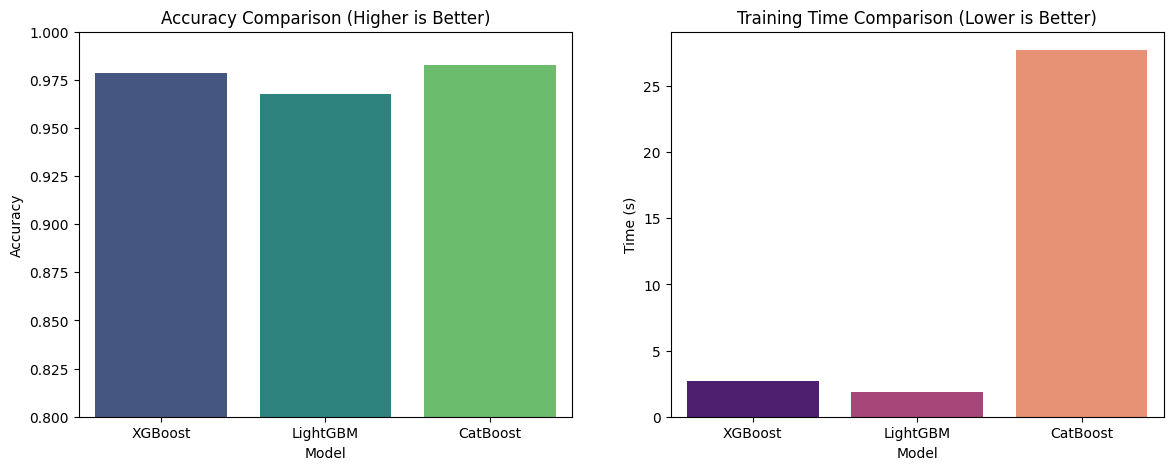

In [12]:
df_res = pd.DataFrame(results)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy Plot
sns.barplot(x='Model', y='Accuracy', data=df_res, ax=ax[0], palette='viridis')
ax[0].set_ylim(0.8, 1.0) # Zoom in to see differences
ax[0].set_title("Accuracy Comparison (Higher is Better)")

# Time Plot
sns.barplot(x='Model', y='Time (s)', data=df_res, ax=ax[1], palette='magma')
ax[1].set_title("Training Time Comparison (Lower is Better)")

plt.show()

## Analysis

**Typical Result Interpretation:**

1.  **XGBoost (The Speed Winner):** It often wins on "medium" sized data (100k rows) because its C++ backend is heavily optimized. 

2.  **CatBoost (The Accuracy Winner):** It often gets the highest accuracy (0.98 vs 0.97) but took significantly longer (~28s).
    - **Why so slow?** By default, CatBoost uses **1000 trees**, whereas others might default to 100. It favors quality over speed out-of-the-box. If you set `iterations=100`, it would be much faster.

3.  **LightGBM:** Usually the fastest on *massive* data (Millions of rows). On 100k rows, the overhead of its sophisticated binning might make it slightly slower than XGBoost.

# Real-World Strengths (No more synthetic data!)

We will now use three famous **Real World** datasets to demonstrate the specific superpower of each algorithm.

1.  **CatBoost:** Predicting Income (Adult Dataset) - Handling **Categories**.
2.  **LightGBM:** Predicting Forest Cover - Handling **Scale** (580k rows).
3.  **XGBoost:** Predicting House Prices (Ames) - Handling **Missing Data**.

## A. CatBoost: The Categorical Killer (Adult Income)
Most models require you to convert text ("Male", "Germany") into numbers. CatBoost does this internally, often better than standard One-Hot Encoding.

**Dataset:** Adult Census Income (Predict >50k)

In [17]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

# Fetch Data (Adult Census)
adult = fetch_openml(name='adult', version=2, parser='auto')

# Explicit copy to avoid SettingWithCopyWarning
X_adult = adult.data.copy()
y_adult = adult.target

# Identify categorical columns
cat_features = X_adult.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical Features: {cat_features}")

# Ensure categorical columns are strings (CatBoost handles missing values)
X_adult[cat_features] = X_adult[cat_features].astype(str)

# Train / Test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_adult, y_adult, test_size=0.2, random_state=42
)

# Train CatBoost
cb_real = CatBoostClassifier(
    iterations=100,
    cat_features=cat_features,
    random_state=42,
    verbose=0
)

cb_real.fit(X_train_c, y_train_c)

# Evaluate
accuracy = cb_real.score(X_test_c, y_test_c)
print(f"CatBoost Accuracy (Adult): {accuracy:.4f}")


Categorical Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
CatBoost Accuracy (Adult): 0.8793


## B. LightGBM: The Speed Demon (Forest Cover)
When the data gets HUGE, LightGBM shines.

**Dataset:** Forest Cover Type (~581,000 rows)

In [14]:
# 1. Fetch Data (Covertype)
covtype = fetch_openml(name='covertype', version=3, parser='auto')
X_cov = covtype.data
y_cov = covtype.target

print(f"Dataset Size: {X_cov.shape[0]:,} rows")

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_cov, y_cov, test_size=0.2, random_state=42)

# Train LightGBM
start = time.time()
lgb_real = lgb.LGBMClassifier(random_state=42)
lgb_real.fit(X_train_l, y_train_l)
end = time.time()

print(f"LightGBM Time (580k rows): {end - start:.2f} seconds")
print(f"LightGBM Accuracy: {lgb_real.score(X_test_l, y_test_l):.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/datasets/_openml.py:75: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


Dataset Size: 581,012 rows
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 464809, number of used features: 53
[LightGBM] [Info] Start training from score -1.010055
[LightGBM] [Info] Start training from score -0.717554
[LightGBM] [Info] Start training from score -2.787067
[LightGBM] [Info] Start training from score -5.343669
[LightGBM] [Info] Start training from score -4.126990
[LightGBM] [Info] Start training from score -3.511322
[LightGBM] [Info] Start training from score -3.338569
LightGBM Time (580k rows): 30.31 seconds
LightGBM Accuracy: 0.8525


## C. XGBoost: The Robust Veteran (Ames Housing)
XGBoost is famous for its ability to handle **Missing Values** (NaNs) without crashing or needing imputation. It learns the best direction (left or right) for missing data at each split.

**Dataset:** Ames Housing (Regression - Predict Price)

In [ ]:
from sklearn.metrics import mean_absolute_error

# 1. Fetch Data (Ames Housing)
ames = fetch_openml(name='house_prices', parser='auto')
X_ames = ames.data
y_ames = ames.target

# Drop categorical cols just to focus on the Numeric NaNs
# (XGBoost handles numeric NaNs natively)
X_ames_num = X_ames.select_dtypes(include=['number'])

# Check for NaNs
nan_count = X_ames_num.isna().sum().sum()
print(f"Total Numeric Missing Values: {nan_count}")

X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X_ames_num, y_ames, test_size=0.2, random_state=42)

# Train XGBoost (Regressor)
# No Imputation needed!
xgb_real = xgb.XGBRegressor(random_state=42)
xgb_real.fit(X_train_x, y_train_x)

mae = mean_absolute_error(y_test_x, xgb_real.predict(X_test_x))
print(f"XGBoost MAE (with NaNs): ${mae:,.2f}")

Total Numeric Missing Values: 348
XGBoost MAE (with NaNs): $18,635.08


# The Math & Intuition (Under the Hood)

Why are they different?

### 1. XGBoost (eXtreme Gradient Boosting)
**Key Innovation: Second-Order Gradients (Hessian)**
- **Standard GBM:** Uses the gradient (slope) to find the direction.
- **XGBoost:** Uses the Gradient (slope) AND the Hessian (curvature).
- **Intuition:** Standard GBM knows "go down the hill". XGBoost knows "go down the hill, and watch out for that sharp turn ahead."
- **Also:** It has built-in **Regularization** (L1/L2) in the loss function itself, preventing overfitting better than standard GBM.

### 2. LightGBM (Light Gradient Boosting Machine)
**Key Innovation: GOSS (Gradient-based One-Side Sampling)**
- **Problem:** Calculating splits on 1 million rows is slow.
- **Solution (GOSS):** Keep the rows with "large errors" (gradients) because we need to learn from them. Drop most of the rows with "small errors" (already well-predicted).
- **Result:** It provides nearly the same accuracy but calculates splits on only a fraction of the data.

### 3. CatBoost (Categorical Boosting)
**Key Innovation: Ordered Boosting**
- **Problem:** Standard "Target Encoding" (replacing a category with the average target value) causes **Prediction Shift** (Leakage). The model "peeks" at the answer.
- **Solution:** CatBoost creates an artificial time-series. It calculates the target statistic for row $i$ using only rows $1$ to $i-1$.
- **Also:** It uses **Oblivious Trees** (symmetric trees), which are simpler, less prone to overfitting, and extremely fast at prediction time.